# Transfer learning
In this exercise, you will apply a convolutional neural network to classify images into ants and bees. Unfortunately, you only have a relatively small dataset available and therefore, your model is likely to overfit. To tackle this issue, you will transfer knowledge that the model got from learning on a different task on a different dataset.

Furthermore, you will try out different strategies to improve generalization in the case of limited training data.

In [1]:
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
import torch.utils.data.sampler
import torch.utils.model_zoo

data_root = "/home/space/datasets/hymenoptera_data"

## Data loading
During training we will use data augmentation to artificially increase the size of our training set (random crops and flips). For evaluation, we crop from the center of the image to have a deterministic measure.

In [2]:
batch_size = 4

# Training set statistics
data_mean = [0.485, 0.456, 0.406]
data_std = [0.229, 0.224, 0.225]

transformations_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std)
    ])
transformations_val = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(data_mean, data_std)
    ])


train_data = datasets.ImageFolder(os.path.join(data_root, "train"), transformations_train)
print(f"Training: Using {len(train_data)} samples of classes {train_data.classes}.")

val_data = datasets.ImageFolder(os.path.join(data_root, "val"), transformations_val)
print(f"Validation: Using {len(val_data)} samples of classes {val_data.classes}.")

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True)

Training: Using 244 samples of classes ['ants', 'bees'].
Validation: Using 153 samples of classes ['ants', 'bees'].


Visualize the first batch of the data. *Note*: The dimensions of Pytorch tensors are ordered as `num_samples x num_channels x width x height` but matplotlib expects the ordering `width x height x num_channels`. You can use `np.moveaxis` or `np.transpose` for this purpose.

In order to display the images correctly, you have to undo the standardization that is done in the data loader above. Remember that the standardization is done according to:
$$
\vec{x}^{*} = \frac{\vec{x} - \vec{\mu}}{\vec{\sigma}} ,
$$
where $\vec{\mu}$ and $\vec{\sigma}$ are the mean and standard deviation of your training set.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(4, 3, 224, 224)
(4, 224, 224, 3)


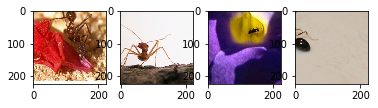

In [53]:
# Get first batch
samples, labels = next(iter(train_loader))

# Convert to numpy array
samples = samples.numpy()
print(samples.shape)

# Reshape to correct ordering that matplotlib understands
samples = np.moveaxis(samples, 1, 3)
print(samples.shape)

# Undo the normalization
reverted_samples = (samples * data_std) + data_mean

fig = plt.figure()
for i in range(samples.shape[0]):
    fig.add_subplot(1,4,i+1)
    plt.imshow(reverted_samples[i])
plt.show()

## Model setup
**Network architecture**: As basis for your experiment you will be provided with an implementation of ResNet18 **[He 2016]**, a popular network architecture that can be considered state of the art for computer vision problems. The network can be loaded by **`models.resnet18()`**.

**Learning rate schedule**: During training, the learning rate is reduced after a couple of epochs using a learning rate scheduler provided by Pytorch. Apart from that, training is done similarly as in the previous exercises.

**[He 2016]** He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.

In [54]:
def train_epoch(model, device, train_loader, optimizer, scheduler):
    model.train()
    optimizer.zero_grad()
    scheduler.step()
    
    losses = list()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        
        loss = nn.CrossEntropyLoss()(output, target)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    return losses

In [55]:
def evaluate(model, device, data_loader):
    model.eval()
    losses = list()
    correct = 0
    num_samples = 0
    
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            prediction = output.max(1, keepdim=True)[1]
            correct += prediction.eq(target.view_as(prediction)).sum().item()
            num_samples += len(data)
    accuracy = 100. * correct / num_samples
    
    return accuracy

In [ ]:
def run_training(model, optimizer, device, train_loader, val_loader, num_epochs=20):
    step_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    train_losses = list()
    train_accuracies = list()
    val_accuracies = list()
    val_epochs = list()

    for epoch in tqdm(range(num_epochs)):
        # Training
        epoch_losses = train_epoch(model, device, train_loader, optimizer, step_lr_scheduler)
        train_losses.append(np.mean(epoch_losses))

        # Evaluation
        if epoch % 5 == 0:
            with torch.no_grad():
                # Evaluate your model on the train and validation set -> `train_accuracy`, `val_accuracy`
                # >>>>> YOUR CODE HERE
                raise NotImplementedError("Replace this line by your code.")
                # <<<<< END YOUR CODE
                    
                train_accuracies.append(train_accuracy) 
                val_accuracies.append(val_accuracy) 
                val_epochs.append(epoch)
    return train_losses, train_accuracies, val_accuracies, val_epochs

In [ ]:
def show_all(train_losses, train_accuracies, val_accuracies, val_epochs):
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.plot(train_losses, color="b", label="Train")
    ax2 = ax1.twinx()
    ax2.set_ylabel('* Accuracy')
    ax2.plot(val_epochs, train_accuracies, color="b", marker="*")
    ax2.plot(val_epochs, val_accuracies, color="r", marker="*")
    fig.legend()
    plt.show()

## Random initialization
As a baseline, we train a randomly initialized network which will later be compared to the model that uses transfer learning.

In [ ]:
device = torch.cuda.current_device()

Load ResNet and save it to the variable `model`. Make sure to make the computations on the GPU. Implement a SGD optimizer and save it to the variable `optimizer`. Recommended hyperparameters: `lr=1e-3`, `momentum=0.9`.

In [ ]:
# >>>>> YOUR CODE HERE
raise NotImplementedError("Replace this line by your code.")
# <<<<< END YOUR CODE

In [ ]:
# Show the model
print(model)

In [ ]:
# Train
result_randominit = \
    run_training(model, optimizer, device, train_loader, val_loader)

In [ ]:
# Show the training curves
show_all(*result_randominit)

## Transfer Learning
You are provided with the parameters that ResNet learned on the ImageNet database. Here is a function to load the pretrained parameters to your model. Those pretrained parameters are then used as initialization for the parameters and finetuned on the ants vs. bees data.

In [ ]:
# Load weights pretrained on ImageNet
def load_weights(model):
    model_dir = "/home/space/datasets/bewo/models"
    model.load_state_dict(torch.utils.model_zoo.load_url("https://download.pytorch.org/models/resnet18-5c106cde.pth", model_dir=model_dir))
    return model

Initialize your model again and load the pretrained parameters.

In [ ]:
# >>>>> YOUR CODE HERE
raise NotImplementedError("Replace this line by your code.")
# <<<<< END YOUR CODE

To be able to train the network on the ants vs. bees problem, modify the last layer of the model accordingly.

The last layer can be accessed by `model.fc`. *Hint*: Each layer in Pytorch has a variable `in_features` that is the number of input features to this layer.

As above define an optimizer and move the model to the GPU.

In [ ]:
## >>>>> YOUR CODE HERE
raise NotImplementedError("Replace this line by your code.")
# <<<<< END YOUR CODE

In [ ]:
# Verify your new architecture
print(model)

In [ ]:
# Finetune the pretrained network on the ants vs. bees data
result_finetuning = \
    run_training(model, optimizer, device, train_loader, val_loader)

In [ ]:
show_all(*result_finetuning)

## Comparison
Compare the validation accuracies with and without pretraining in a single plot. What do you observe?

In [ ]:
plt.figure()
# >>>>> YOUR CODE HERE
raise NotImplementedError("Replace this line by your code.")
# <<<<< END YOUR CODE
plt.show()

## Optional Exercise: Feature extraction
Use the pretrained ResNet as a feature extractor without finetuning it. This means that only the last layer is learned.
To freeze the feature extraction layers, run the following:
```
for param in model.parameters():
    param.requires_grad = False
```

Furthermore, use the extracted features as input to a different type of classifier, e.g. an SVM or logistic regression model provided by *Scikit Learn*.